# Ewaluacja predykcji szeregów czasowych

In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [30]:
from statsmodels.tsa.stattools import adfuller
def check_time_series_stationary(y, rolling_len = 12):
    
    y = pd.Series(y)
    
    df_test = adfuller(y)
    
    if df_test[1] < 0.05:
        print('Szereg jest stacjonarny')
    else:
        print('Szereg jest niestacjonarny')
    
    print("{0:^32s}".format("Dickey-Fuller Test"))
    print("-"*32+"\n")
    
    print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
    print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
    print("-"*32+"\n")
    
    rolling_mean = y.rolling(rolling_len).mean()
    rolling_var = y.rolling(rolling_len).var()

    plt.plot(y)
    plt.plot(rolling_mean, label="Rolling mean")
    plt.plot(rolling_var, label="Rolling var")
    plt.legend()
    plt.show()
    
    print("{0:^32s}".format("Autocorrelation plot"))
    print("-"*32+"\n")
    pd.plotting.autocorrelation_plot(y)
    plt.show()

Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :     2.9819
p-value             :     1.0000
--------------------------------



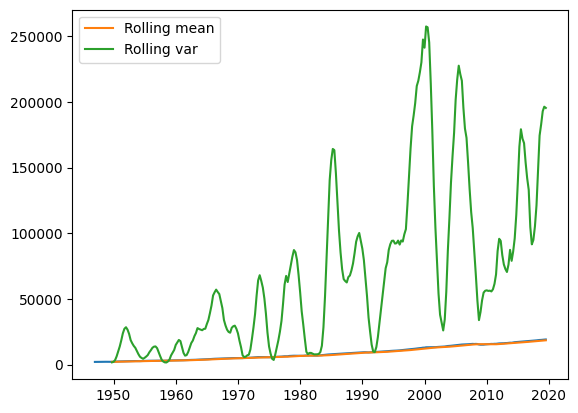

      Autocorrelation plot      
--------------------------------



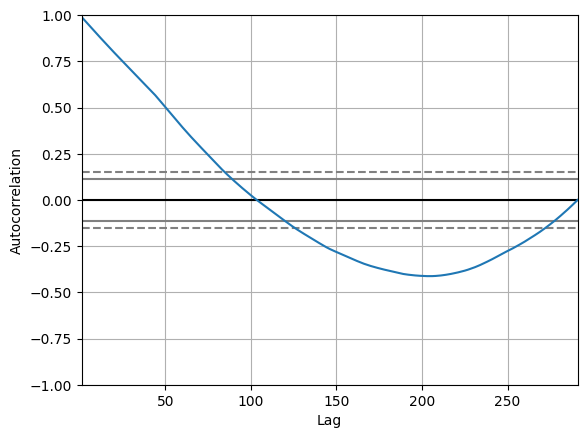

In [31]:
usgdp = pd.read_csv('USGDP.csv', 
                 parse_dates=['DATE'], index_col='DATE')

usgdp.head()
check_time_series_stationary(usgdp.GDPC1)

### Podział na część treningową i część testową

Ocena dokładności na podstawie tych samych danych, które były wykorzystane do konstrukcji prognozu, nie pozwala na w pełni wiarygodną ocenę skuteczności i może prowadzić do błędnych wniosków. Aby wiarygodnie porównać skuteczność różnych metod prognozowania, powinniśmy wykorzystać niezależne dane testowe.

W tym celu szereg dzielimy na:
- **część treningową** - wykorzystaną do dopasowania modelu i konstrukcji prognoz,
- **część testową** - wykorzystaną do oceny dokładności prognoz.

In [32]:
k = int(usgdp.size*0.8)
usgdp_train = usgdp[:k]
usgdp_test = usgdp[k:]

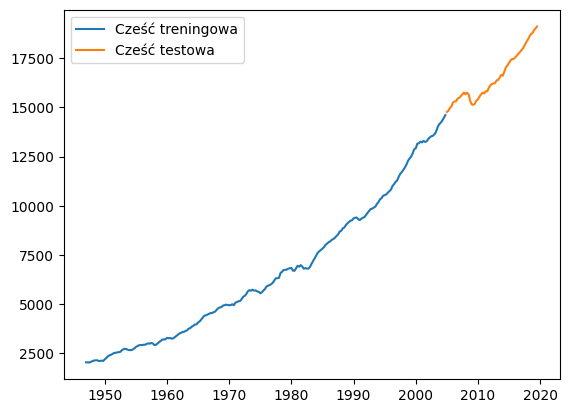

In [33]:
plt.plot(usgdp_train,label='Cześć treningowa')
plt.plot(usgdp_test,label='Cześć testowa')
plt.legend()
plt.show()

In [34]:
np.min(usgdp_test.index), np.max(usgdp_test.index)

(Timestamp('2005-01-01 00:00:00'), Timestamp('2019-07-01 00:00:00'))

In [35]:
log_usgdp_train = np.log(usgdp_train)
m1 = ARIMA(endog=log_usgdp_train, order=(3, 1, 2),trend = 't').fit()#wybrany z analiz z poprzedniego zadania, 
                                                                    #choć tu powinniśmy to rozumowanie z poprzedniej kartki przeprowadzić 
                                                                    #dla traina
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  GDPC1   No. Observations:                  232
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 758.409
Date:                Sun, 04 Jun 2023   AIC                          -1502.817
Time:                        23:48:35   BIC                          -1478.720
Sample:                    01-01-1947   HQIC                         -1493.098
                         - 10-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0085      0.001     16.995      0.000       0.008       0.010
ar.L1          1.0918      0.343      3.186      0.001       0.420       1.763
ar.L2         -0.0032      0.439     -0.007      0.994      -0.863       0.857
ar.L3         -0.2463      0.126     -1.949      0.051      -0.494       0.001
ma.L1         -0.7978      0.348     -2.291      0.022      -1.480      -0.115
ma.L2         -0.0841      0.337     -0.250      0.803      -0.744       0.576
sigma2      8.218e-05   5.79e-06     14.203      0.000    7.08e-05    9.35e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                27.16
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
predict_test = np.exp(m1.predict(start='2005-01-01',end='2019-07-01',dynamic=True))

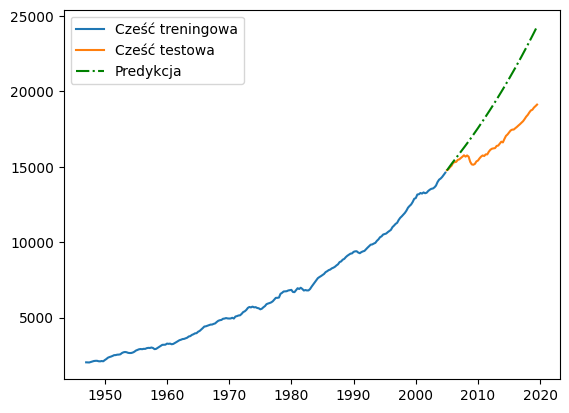

In [37]:
plt.plot(usgdp_train,label='Cześć treningowa')
plt.plot(usgdp_test,label='Cześć testowa')
plt.plot(predict_test,'g-.',label='Predykcja')
plt.legend()
plt.show()

## Zadanie 1

Napisz funkcję, która znajdzie najlepszy model ARMA - pamiętaj o podziale zbioru na część treningową i testową.

In [38]:
def mse(y, yhat):
    return np.mean((y - yhat) ** 2)

def mae(y, yhat):
    return np.median(np.abs(y - yhat))

In [41]:
def find_the_best_arima(ts, max_p = 10, max_q=10, split=0.8):
    
    k = int(ts.size * split)
    ts_train = ts[:k]
    ts_test = ts[k:]

    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))
    mse2 = np.zeros((max_p, max_q))
    mae2 = np.zeros((max_p, max_q))
    
    for i in range(max_p):
        for j in range(max_q):
            try:
                arima = ARIMA(ts_train, order=(i + 1, 1, j + 1),trend = 't').fit()
                aic[i, j] = arima.aic
                bic[i, j] = arima.bic
                print('ARIMA(%d,1,%d): AIC=%f, BIC=%f' % (i+1, j+1, arima.aic, arima.bic))

                arima_pred = arima.predict(start=str(np.min(ts_test.index).year), end=str(np.max(ts_test.index).year), 
                                         dynamic=True)
                mse2[i, j] = mse(ts_test.values, arima_pred.values)
                mae2[i, j] = mae(ts_test.values, arima_pred.values)
            except:
                aic[i, j] = bic[i, j] = mse2[i, j] = mae2[i, j] = np.Inf
            
    print("-" * 30)
    min_aic = np.min(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0]
    print("MINIMUM AIC=%f dla p=%d, q=%d" % (min_aic, min_arg_aic[0] + 1, min_arg_aic[1] + 1))
    min_bic = np.min(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0]
    print("MINIMUM BIC=%f dla p=%d, q=%d" % (min_bic, min_arg_bic[0] + 1, min_arg_bic[1] + 1))
    
    min_mse = np.min(mse2)
    min_arg_mse = np.argwhere(mse2 == min_mse)[0]
    print("MINIMUM MSE=%f dla p=%d, q=%d" % (min_mse, min_arg_mse[0] + 1, min_arg_mse[1] + 1))
    
    min_mae = np.min(mae2)
    min_arg_mae = np.argwhere(mae2 == min_mae)[0]
    print("MINIMUM MAE=%f dla p=%d, q=%d" % (min_mae, min_arg_mae[0] + 1, min_arg_mae[1] + 1))

In [42]:
find_the_best_arima(log_usgdp_train, 7, 7) #szukamy modelu o najlepszym AIC, BIC, MSE i MAE 
                                            #(te dwie ostatnie wyliczone na zbiorze walidacyjnym,
                                            #dzielimy wewnątrz funkcji zbiór log_usgdp_train
                                            #na część na której uczymy i część która nam służy do policzenia
                                            #MSE lub MAE celem wyboru optymalnego p i q)
                                            #później zparoponowane przez te miary modele dopasowujemy na pełnym
                                            #log_usgdp_train i patrzymy na predykcje na daily_biths_test (dokładamy expa bo szereg zlogarytmizowany)

ARIMA(1,1,1): AIC=-1162.758979, BIC=-1149.899235
ARIMA(1,1,2): AIC=-1162.935774, BIC=-1146.861095
ARIMA(1,1,3): AIC=-1161.716151, BIC=-1142.426536
ARIMA(1,1,4): AIC=-1164.208040, BIC=-1141.703490
ARIMA(1,1,5): AIC=-1162.610180, BIC=-1136.890693
ARIMA(1,1,6): AIC=-1161.367462, BIC=-1132.433040
ARIMA(1,1,7): AIC=-1161.066179, BIC=-1128.916821
ARIMA(2,1,1): AIC=-1162.107188, BIC=-1146.032509
ARIMA(2,1,2): AIC=-1164.581837, BIC=-1145.292222
ARIMA(2,1,3): AIC=-1163.832762, BIC=-1141.328212
ARIMA(2,1,4): AIC=-1161.059524, BIC=-1135.340038
ARIMA(2,1,5): AIC=-1160.419616, BIC=-1131.485194
ARIMA(2,1,6): AIC=-1157.624572, BIC=-1125.475215
ARIMA(2,1,7): AIC=-1161.905489, BIC=-1126.541196
ARIMA(3,1,1): AIC=-1162.387363, BIC=-1143.097749
ARIMA(3,1,2): AIC=-1163.368918, BIC=-1140.864368
ARIMA(3,1,3): AIC=-1162.419747, BIC=-1136.700261
ARIMA(3,1,4): AIC=-1160.176364, BIC=-1131.241942
ARIMA(3,1,5): AIC=-1158.127868, BIC=-1125.978511
ARIMA(3,1,6): AIC=-1155.576115, BIC=-1120.211821
ARIMA(3,1,7): AIC=-1

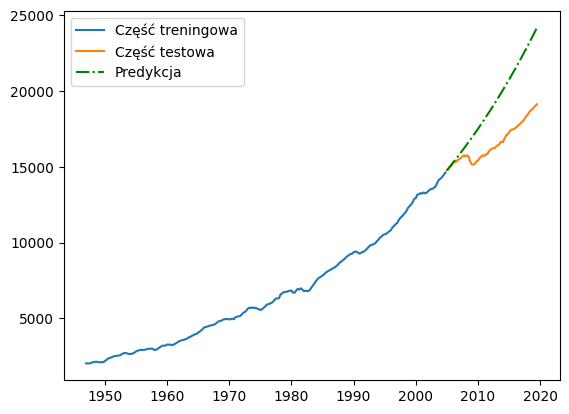

In [43]:
arima2_1_2 = ARIMA(log_usgdp_train, order=(2, 1, 2),trend = 't').fit()
arima2_1_2_predict = np.exp(arima2_1_2.predict(start='2005-01-01',end='2019-07-01',dynamic=True))
plt.plot(usgdp_train, label="Część treningowa")
plt.plot(usgdp_test, label="Część testowa")
plt.plot(arima2_1_2_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

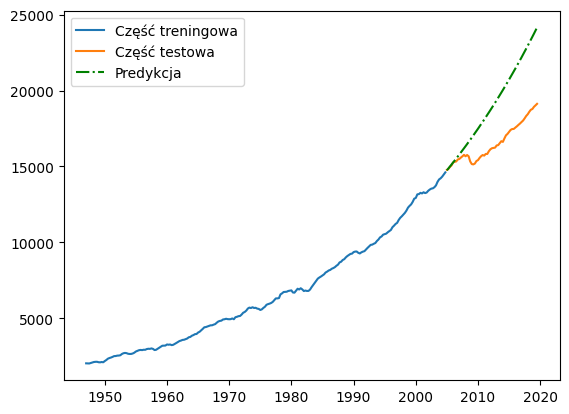

In [44]:
arima1_1_1 = ARIMA(log_usgdp_train, order=(1, 1, 1),trend = 't').fit()
arima1_1_1_predict = np.exp(arima1_1_1.predict(start='2005-01-01',end='2019-07-01',dynamic=True))
plt.plot(usgdp_train, label="Część treningowa")
plt.plot(usgdp_test, label="Część testowa")
plt.plot(arima1_1_1_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show() 

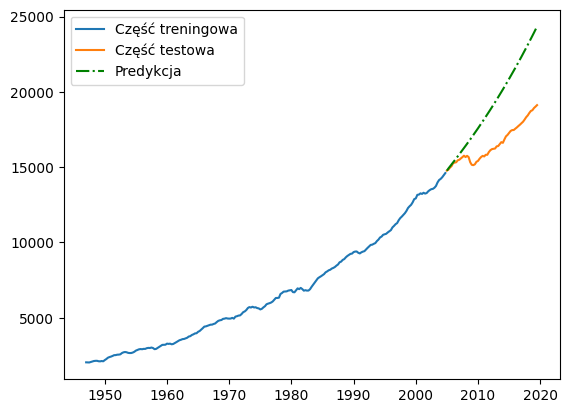

In [45]:
arima3_1_5 = ARIMA(log_usgdp_train, order=(3, 1, 5),trend = 't').fit()
arima3_1_5_predict = np.exp(arima3_1_5.predict(start='2005-01-01',end='2019-07-01',dynamic=True))
plt.plot(usgdp_train, label="Część treningowa")
plt.plot(usgdp_test, label="Część testowa")
plt.plot(arima3_1_5_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

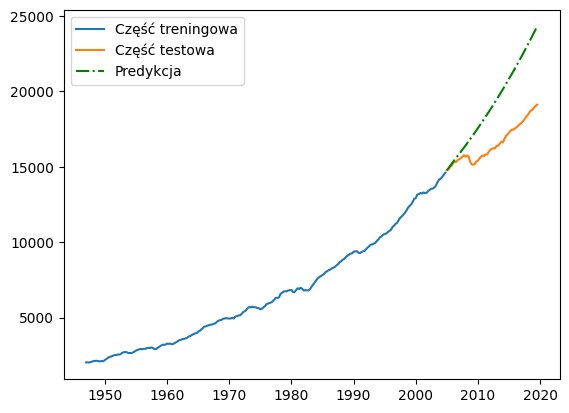

In [46]:
arima3_1_2 = ARIMA(log_usgdp_train, order=(3, 1, 2),trend = 't').fit()
arima3_1_2_predict = np.exp(arima3_1_2.predict(start='2005-01-01',end='2019-07-01',dynamic=True))
plt.plot(usgdp_train, label="Część treningowa")
plt.plot(usgdp_test, label="Część testowa")
plt.plot(arima3_1_2_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

In [ ]:
#modele porównywalne, można wybraćten o najmniejszej liczbie parametrów, aczkolwiek można porównać MSE i MAE między nimi

## Kroswalidacja

In [48]:
from sklearn.model_selection import TimeSeriesSplit

TRAIN: (0, 74)
TEST: (75, 146)


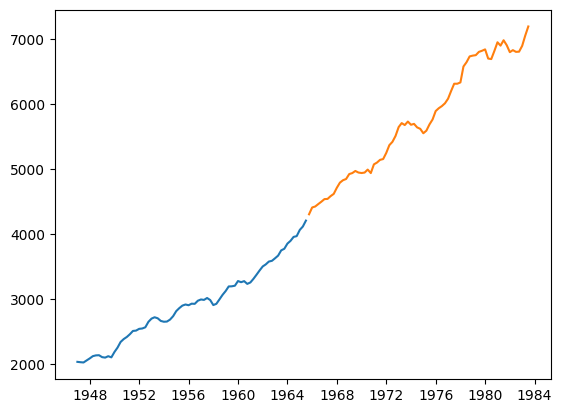

TRAIN: (0, 146)
TEST: (147, 218)


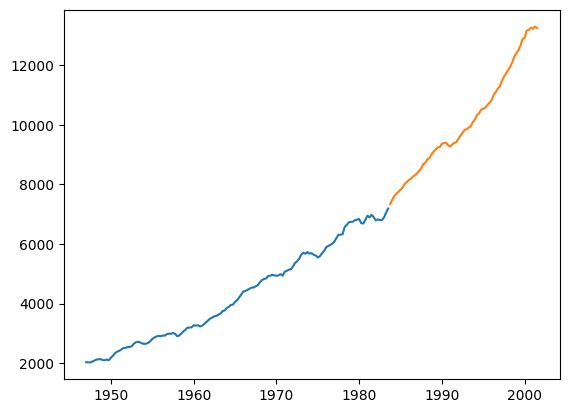

TRAIN: (0, 218)
TEST: (219, 290)


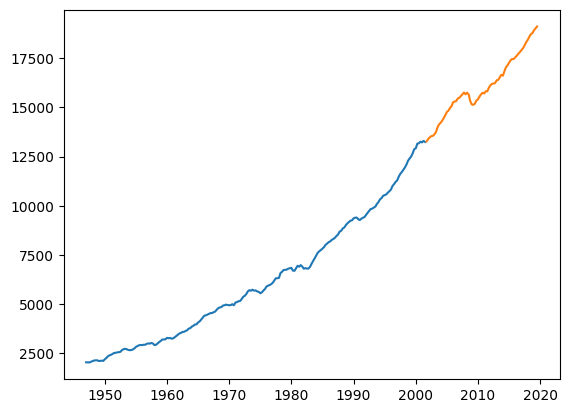

In [49]:
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(usgdp.values):
    print("TRAIN: (%d, %d)" % (min(train_index), max(train_index)))
    print("TEST: (%d, %d)" % (min(test_index), max(test_index)))
    
    train, test = usgdp.iloc[train_index], usgdp.iloc[test_index]
    plt.plot(train)
    plt.plot(test)
    plt.show()

In [ ]:
#kroswalidacja w szeregach czasowych wygląda nieco inaczej na początek bierzemy pierwszą jedną czwartą zbioru do uczenia i kolejną jedną czwartą do testowego
#następnie bierzemy pierwsze dwie czwarte zbioru do uczenia i kolejną jedną czwartą do testowego
#na koniec pierwsze trzy czwarte zbioru do uczenia i ostatnią jedną czwartą do testowego

## Zadanie 2

Napisz funkcję, która znajdzie najlepszy model ARMA - użyj kroswalidacji.

In [53]:
def find_the_best_arima_crossal(ts, max_p = 10, max_q=10, ar = False, cross=5):
    tscv = TimeSeriesSplit(n_splits=cross)
    
    aic = np.zeros((max_p + 1, max_q + 1))
    bic = np.zeros((max_p + 1, max_q + 1))
    mae_values = np.zeros((max_p + 1, max_q + 1))
    mse_values = np.zeros((max_p + 1, max_q + 1))
    
    for i in range(max_p + 1):
        for j in range(max_q + 1):
            if (i == j == 0):
                aic[0, 0] = bic[0, 0] = mae_values[0, 0] = mse_values[0, 0] = np.Inf
            elif (i == 0) | ((not ar) & (j == 0)):
                aic[i, j] = bic[i, j] = mae_values[i, j] = mse_values[i, j] = np.Inf
            else:
                aic_cross, bic_cross, mse_cross, mae_cross = [], [], [], []
                for train_index, test_index in tscv.split(ts.values):
                    train, test = ts.iloc[train_index], ts.iloc[test_index]
                    arma = ARIMA(train, order=(i, 1, j),trend='t').fit()
                    aic_cross.append(arma.aic)
                    bic_cross.append(arma.bic)
                    pred = arma.predict(start=str(np.min(test.index).year), end=str(np.max(test.index).year), dynamic=True)
                    mse_cross.append(mse(test.values, pred.values))
                    mae_cross.append(mae(test.values, pred.values))
                    
                aic[i, j] = np.mean(aic_cross)
                bic[i, j] = np.mean(arma.bic)
                mae_values[i, j] = np.nanmean(mae_cross)
                mse_values[i, j] = np.nanmean(mse_cross)
                print("ARIMA(%d,1,%d): AIC=%f; BIC=%f; MSE=%f; MAE=%f" % (i, j, arma.aic, arma.bic, 
                                                                        mse_values[i, j], mae_values[i, j]))

    print("-" * 30)
    min_aic = np.nanmin(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0] 
    print("MINIMUM AIC=%f for p=%d, q=%d" % (min_aic, min_arg_aic[0], min_arg_aic[1]))
    
    min_bic = np.nanmin(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0] 
    print("MINIMUM BIC=%f for p=%d, q=%d" % (min_bic, min_arg_bic[0], min_arg_bic[1]))
    
    min_mse = np.nanmin(mse_values)
    min_arg_mse = np.argwhere(mse_values == min_mse)[0]
    print("MINIMUM MSE=%f for p=%d, q=%d" % (min_mse, min_arg_mse[0], min_arg_mse[1]))
    
    min_mae = np.nanmin(mae_values)
    min_arg_mae = np.argwhere(mae_values == min_mae)[0]
    print("MINIMUM MAE=%f for p=%d, q=%d" % (min_mae, min_arg_mae[0], min_arg_mae[1]))

In [54]:
find_the_best_arima_crossal(log_usgdp_train, 7, 7, cross=4)
#na treningowym zlogarytmizowanym robimy kroswalidację to znaczy w każdym obrocie pętli na części zbioru dopasowujemy model a na kolejnej części licząc na niej MSE, czy MAE sprawdzamy
#który z modeli jest najlepszy
#później użyjemy testowego, który nie był w kroswalidacji do sprawdzenia jakości predykcji 

ARIMA(1,1,1): AIC=-1170.122753; BIC=-1157.241330; MSE=0.029373; MAE=0.123127
ARIMA(1,1,2): AIC=-1170.308821; BIC=-1154.207042; MSE=0.029302; MAE=0.122892
ARIMA(1,1,3): AIC=-1169.040374; BIC=-1149.718239; MSE=0.029971; MAE=0.123920
ARIMA(1,1,4): AIC=-1170.035675; BIC=-1147.493184; MSE=0.029958; MAE=0.123903
ARIMA(1,1,5): AIC=-1170.001888; BIC=-1144.239042; MSE=0.030156; MAE=0.124529
ARIMA(1,1,6): AIC=-1168.784758; BIC=-1139.801556; MSE=0.029993; MAE=0.124029
ARIMA(1,1,7): AIC=-1167.753534; BIC=-1135.549976; MSE=0.030281; MAE=0.124331
ARIMA(2,1,1): AIC=-1170.497623; BIC=-1154.395844; MSE=0.029352; MAE=0.123056
ARIMA(2,1,2): AIC=-1171.943633; BIC=-1152.621498; MSE=0.029789; MAE=0.123586
ARIMA(2,1,3): AIC=-1171.727568; BIC=-1149.185077; MSE=0.029932; MAE=0.123814
ARIMA(2,1,4): AIC=-1168.639115; BIC=-1142.876268; MSE=0.030112; MAE=0.124396
ARIMA(2,1,5): AIC=-1167.905728; BIC=-1138.922526; MSE=0.030206; MAE=0.124576
ARIMA(2,1,6): AIC=-1165.068427; BIC=-1132.864869; MSE=0.030044; MAE=0.124025

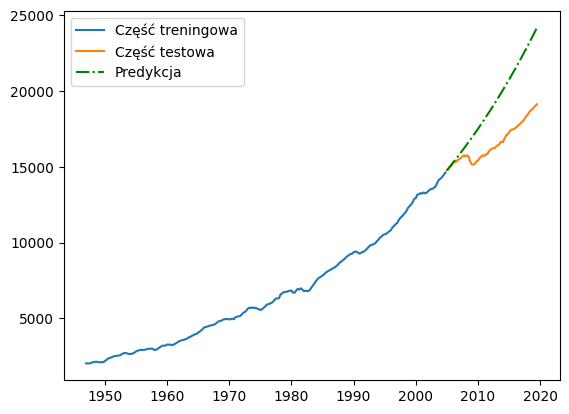

In [56]:
arima2_1_2 = ARIMA(log_usgdp_train, order=(2, 1, 2),trend = 't').fit()
arima2_1_2_predict = np.exp(arima2_1_2.predict(start='2005-01-01',end='2019-07-01',dynamic=True))
plt.plot(usgdp_train, label="Część treningowa")
plt.plot(usgdp_test, label="Część testowa")
plt.plot(arima2_1_2_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

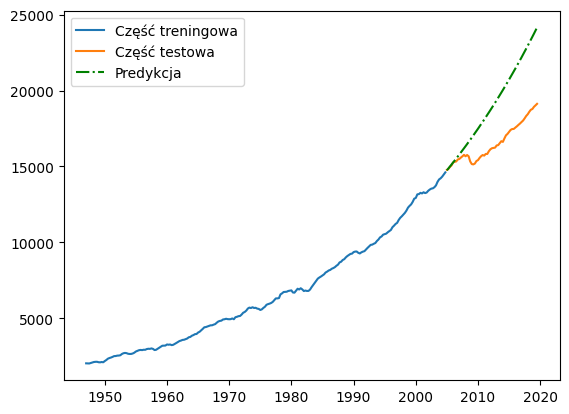

In [57]:
arima1_1_1 = ARIMA(log_usgdp_train, order=(1, 1, 1),trend = 't').fit()
arima1_1_1_predict = np.exp(arima1_1_1.predict(start='2005-01-01',end='2019-07-01',dynamic=True))
plt.plot(usgdp_train, label="Część treningowa")
plt.plot(usgdp_test, label="Część testowa")
plt.plot(arima1_1_1_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

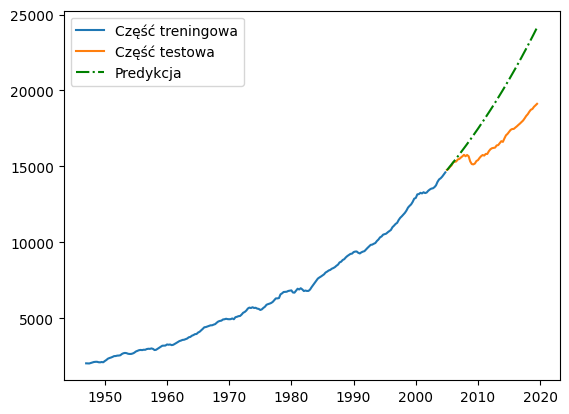

In [58]:
arima1_1_2 = ARIMA(log_usgdp_train, order=(1, 1, 2),trend = 't').fit()
arima1_1_2_predict = np.exp(arima1_1_2.predict(start='2005-01-01',end='2019-07-01',dynamic=True))
plt.plot(usgdp_train, label="Część treningowa")
plt.plot(usgdp_test, label="Część testowa")
plt.plot(arima1_1_2_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

In [ ]:
#podobnie jak wcześniej modele porównywalne, można wybraćten o najmniejszej liczbie parametrów, aczkolwiek można porównać MSE i MAE między nimi

# Predykcja z wykorzystaniem danych historycznych

In [ ]:
#tutaj tworzymy predykcję dla obserwacji na podstawie struktury opisanej w modelu i konkretnych danych, które mają wcześniejsze indeksy czasowe
#w kolejnym kroku nie bierzemy predykcji, którą uzyskaliśmy dla wcześniejszej obserwacji, tylko prawdziwą wartość szeregu 

In [65]:
history = log_usgdp_train.values.tolist()
prediction = []
simple_prediction = []
errors = []
test = usgdp_test.values

for t in range(len(test)):
    model = ARIMA(history, order=(3, 1, 2)).fit()
    pred = np.exp(model.forecast()[0])
    prediction.append(pred)
    simple_prediction.append(np.exp(history[-1][0]))
    history.append(np.log(test[t]))
    
    errors.append((pred - test[t])**2)

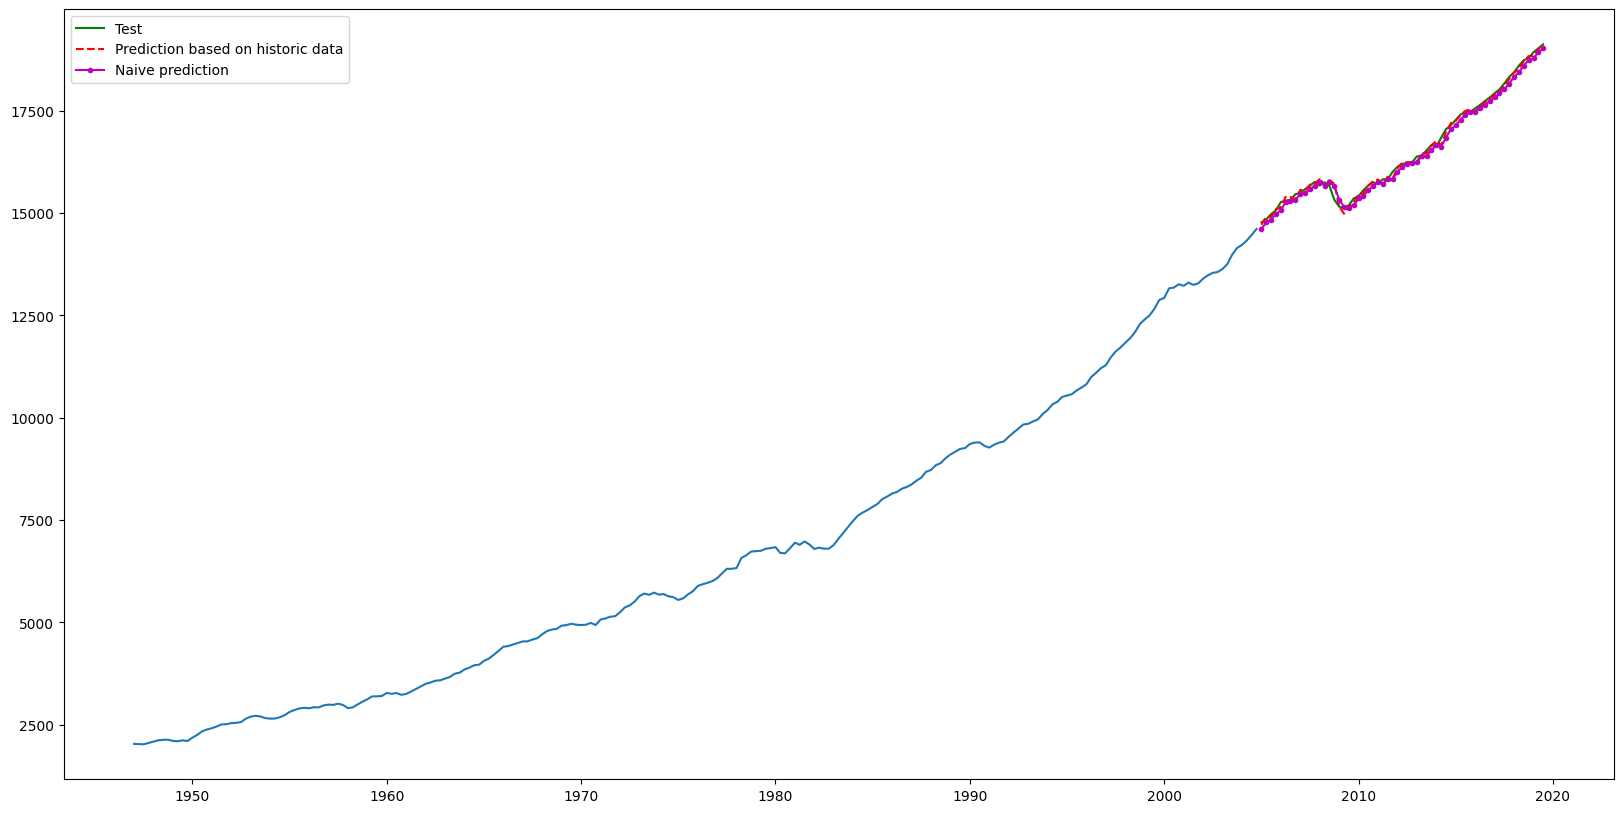

In [71]:
plt.figure(figsize=(20, 10))

plt.plot(usgdp_train)
plt.plot(usgdp_test, 'g-', label="Test")
plt.plot(pd.Series(prediction, index=usgdp_test.index), 'r--', label="Prediction based on historic data")
plt.plot(pd.Series(simple_prediction, index=usgdp_test.index), 'm.-', label="Naive prediction") #naiwna predykcja to wzięcie po prostu 
#wcześniejszej obserwacji jako predykcji następnej
plt.legend()
plt.show()